ChaoTang

In [73]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
import os # for reading all files in a folder
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

# Part H: Tracking and Homographies

In this part we use Practical 9c to track the positions of the four corners of the square and project a cube into the images. 

TO DO: QUESTIONS TO THINK ABOUT...

- Do the results look realistic? 
- If not then what factors do you think might be causing this


TO DO: your routines for computing a homography and extracting a valid rotation and translation go in the code below. Tips:
- you may define functions for T and H matrices respectively.
- you may need to turn the points into homogeneous form before any other computation. 
- you may need to solve a linear system in Ah = 0 form. Write your own routines or using the builtin function 'svd'. 
- you may apply the direct linear transform (DLT) algorithm to recover the best homography H.
- you may explain what & why you did in the report.


In [94]:
#Likelihood function is simple patch similarity
#Note that below, we add a few 'corrections', such as
#manually masking out the sky for better results
def computeLikelihood(image, template):
    #opencv's available methods - experiment with these
    #careful what range the output is!
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    likelihood = cv.matchTemplate(image, template, methods[0])
    #we manually eliminate incorrect matches in the sky
    #since we know that there cannot be any cars in those areas
    likelihood[likelihood<20000000] = 0 # set a threshold for the 
    
    #we can then pad to make this the size of the input image (for easier indexing)
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((pad_first, pad_first), (pad_second, pad_second))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    
    return likelihood

In [95]:
# TO DO: Copy and paste the function HW2_Practical9c in here. 

def HW2_Practical9c(corner):
    template = sp.io.loadmat(corner+'.mat')['pixelsTemplate']
    #let's show the template
    print('We are matching this template with shape: ', template.shape)
    plt.imshow(template)
    plt.show()

    # Load all images in folder
    images = []
    iFrame = 0
    folder = 'extra/'
    a = os.listdir(folder)
    for frameNum in a:
        images.append(cv.imread(folder+frameNum))
        iFrame += 1
    # plot first image 
    plt.imshow(images[0])
    plt.show()

    imgHeight, imgWidth, colors = images[0].shape
    numParticles = 2000;
    weight_of_samples = np.ones((numParticles,1))

    # TO DO: normalize the weights (may be trivial this time) [done]
    weight_of_samples = weight_of_samples/np.sum(weight_of_samples)

    # Initialize which samples from "last time" we want to propagate: all of
    # them!:
    samples_to_propagate = range(0, numParticles)


    # ============================
    # NOT A TO DO: You don't need to change the code below, but eventually you may
    # want to vary the number of Dims (compare for example to lab 9b) 
    numDims_w = 2;
    # Here we randomly initialize some particles throughout the space of w:
    particles_old = np.random.rand(numParticles, numDims_w)
    particles_old[:,0] = particles_old[:,0] * imgHeight
    particles_old[:,1] = particles_old[:,1] * imgWidth
    # ============================

    #Initialize a temporary array r to store the per-frame MAP estimate of w. This is what we'll return in the end.
    r = np.zeros((iFrame, numDims_w));

    for iTime in range(iFrame):
        print('Processing Frame', iTime)
        # TO DO: compute the cumulative sume of the weights. [done]
        cum_hist_of_weights = np.linspace(0, 1, numParticles) # replace this
        #print(weight_of_samples)
        for icum in range(numParticles):
            cum_hist_of_weights[icum] = np.sum(weight_of_samples[0:icum + 1])

        # ==============================================================
        # Resample the old distribution at time t-1, and select samples, favoring
        # those that had a higher posterior probability.
        # ==============================================================
        samples_to_propagate = np.zeros(numParticles, dtype=np.int32)

        # Pick random thresholds in the cumulative probability's range [0,1]:
        some_threshes = np.random.rand(numParticles)


        # For each random threshold, find which sample in the ordered set is
        # the first one to push the cumulative probability above that
        # threshold, e.g. if the cumulative histogram goes from 0.23 to 0.26
        # between the 17th and 18th samples in the old distribution, and the
        # threshold is 0.234, then we'll want to propagate the 18th sample's w
        # (i.e. particle #18).

        for sampNum in range(numParticles): 
            thresh = some_threshes[sampNum]
            for index in range (numParticles):
                if cum_hist_of_weights[index] > thresh:
                    break
            samples_to_propagate[sampNum] = index

        # Note: it's ok if some of the old particles get picked repeatedly, while
        # others don't get picked at all.


        # =================================================
        # Visualize if you want
        # =================================================
        #plt.title('Cumulative histogram of probabilities for sorted list of particles')
        #plt.plot(np.zeros(numParticles), some_threshes,'b.')
        #plt.plot(range(0, numParticles), cum_hist_of_weights, 'rx-')
        #which_sample_ids = np.unique(samples_to_propagate)
        #how_many_of_each = np.bincount(np.ravel(samples_to_propagate))
        #for k in range(len(which_sample_ids)):
        #    plt.plot(which_sample_ids[k], 0, 'bo-', markersize = 3 * how_many_of_each[k], markerfacecolor='white')
        #plt.xlabel('Indeces of all available samples, with larger blue circles for frequently re-sampled particles\n(Iteration %01d)' % iTime)
        #plt.ylabel('Cumulative probability');
        #plt.show()
        # =================================================
        # =================================================

        # Predict where the particles we sampled from the old distribution of 
        # state-space will go in the next time-step. This means we have to apply 
        # the motion model to each old sample.
        particles_new = np.zeros_like(particles_old)
        for particleNum in range(numParticles):
            # TO DO: Incorporate some noise, e.g. Gaussian noise with std 20,
            # into the current location (particles_old), to give a Brownian
            # motion model.
            # particles_new[particleNum, :] =  particles_old[particleNum, :] # replace this 
            particles_new[particleNum, :] = particles_old[samples_to_propagate[particleNum],:] + np.random.normal(0,50,2)
            
        # TO DO: Not initially, but change the motion model above to have
        # different degrees of freedom, and optionally completely different
        # motion models. 
        # See Extra Credit for more instructions.

        #calculate likelihood function
        likelihood = computeLikelihood(images[iTime], template)
        
        if iTime < 11:
            #plot results
            f, axarr = plt.subplots(1, 2)
            axarr[0].imshow(images[iTime])
            axarr[0].set_title('Particles')
            # now draw the particles onto the image
            axarr[0].plot(particles_new[:,1]+template.shape[1]/2, particles_new[:,0]+template.shape[0]/2, 'rx')

            #plot the likelihood
            axarr[1].imshow(likelihood)
            axarr[1].set_title('Likelihood')

        # From here we incorporate the data for the new state (time t):
        # The new particles accompanying predicted locations in state-space
        # for time t, are missing their weights: how well does each particle
        # explain the observations x_t?
        for particleNum in range(numParticles):

            # Convert the particle from state-space w to measurement-space x:
            # Note: that step is trivial here since both are in 2D space of image
            # coordinates

            # Within the loop, we evaluate the likelihood of each particle:
            particle = particles_new[particleNum, :]
            # Check that the predicted location is a place we can really evaluate
            # the likelihood.
            inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
            if inFrame:
                minX = particle[1]
                minY = particle[0]

                weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]

            else:
                weight_of_samples[particleNum] = 0.0

        # TO DO: normalize the weights [done]
        weight_of_samples = weight_of_samples/np.sum(weight_of_samples)#replace this
        
        # find the location of the particle with highest weight
        indices = np.argsort(weight_of_samples,0)
        bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
        r[iTime,:] = bestScoringParticles[-1,1]+template.shape[1]/2,bestScoringParticles[-1,0]+template.shape[0]/2
        if iTime < 11:
            plt.plot(bestScoringParticles[-1:,1], bestScoringParticles[-1:,0], 'rx')
            # Return the MAP of middle position. Add template.shape/2 because matchTemplate finds the position of the upper left corner 
            # of the template. We want to plot the centre of the template. 
            print(r[iTime,:])   
            plt.show()
        
            #print the original image and the position of the tracked corner.
            plt.imshow(images[iTime])
            plt.plot(r[iTime,0],r[iTime,1],'rx')
            plt.show()
        # Now we're done updating the state for time t. 
        # For Condensation, just clean up and prepare for the next round of 
        # predictions and measurements:
        particles_old = particles_new

    return r

We are matching this template with shape:  (51, 55, 3)


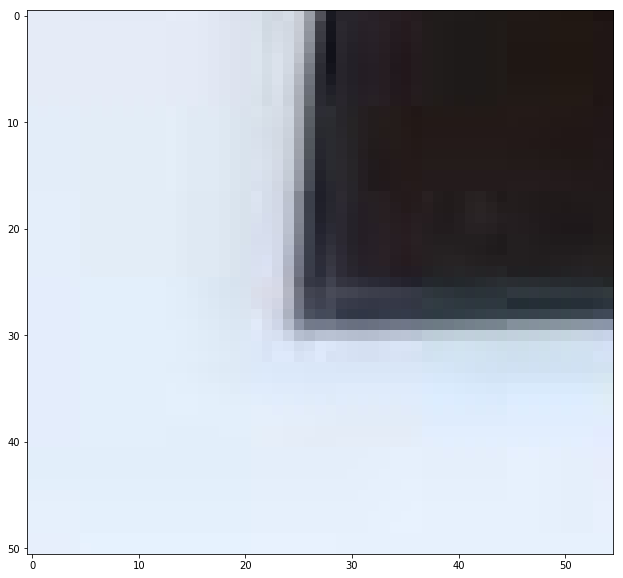

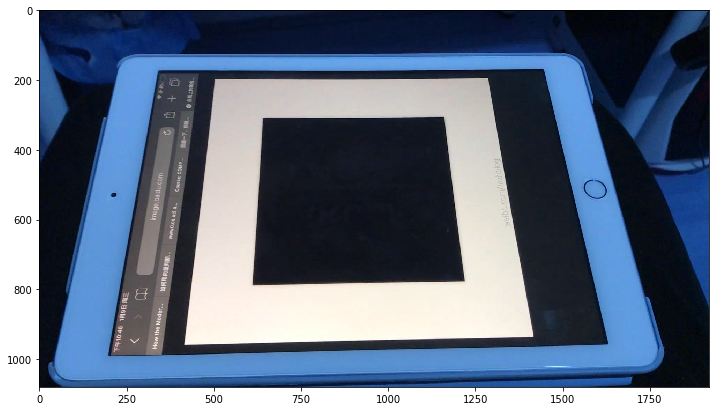

Processing Frame 0
[673.81947276 825.36133999]


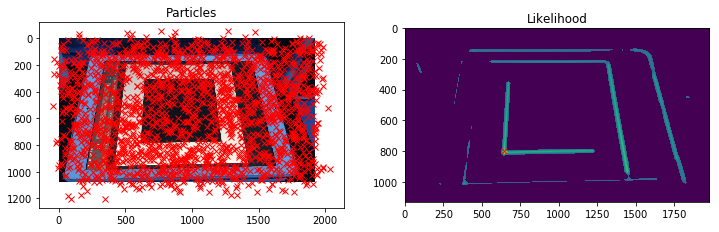

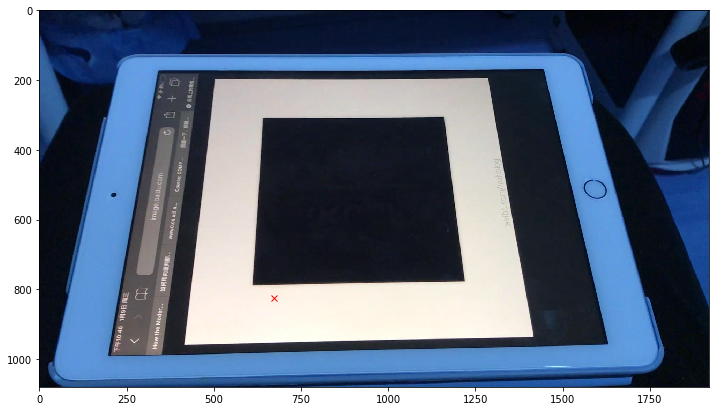

Processing Frame 1
[931.65582548 804.57783612]


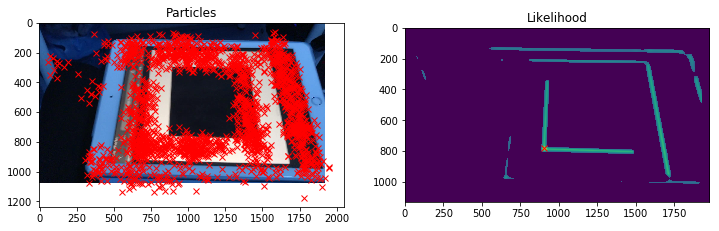

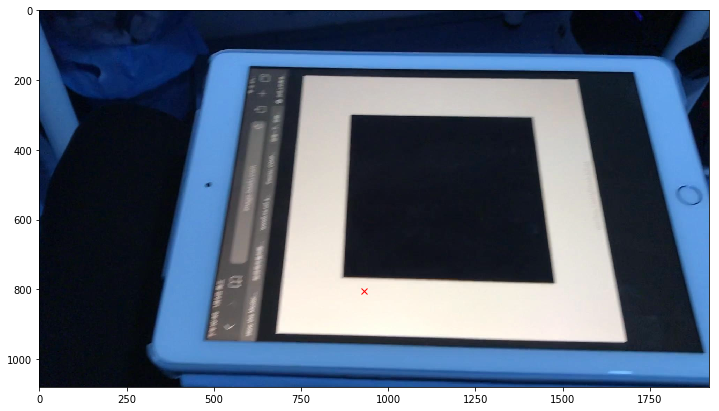

Processing Frame 2
[964.85825766 791.23439703]


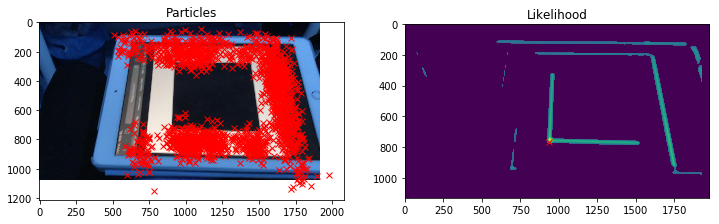

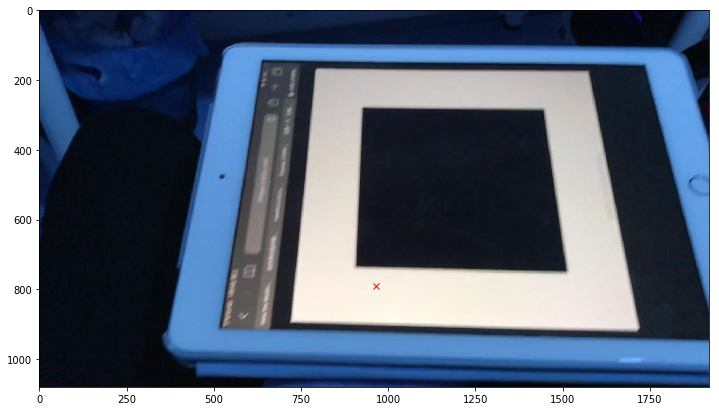

Processing Frame 3
[983.85254093 739.61982372]


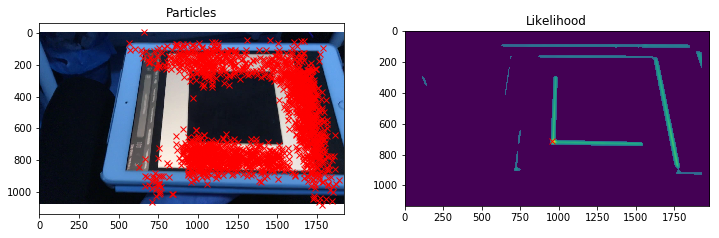

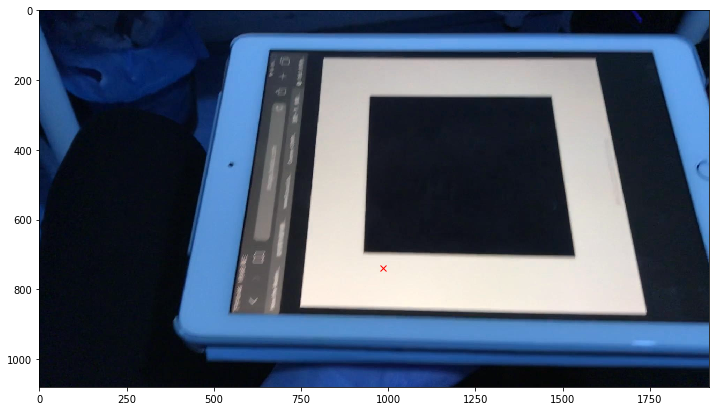

Processing Frame 4
[996.25795319 688.115252  ]


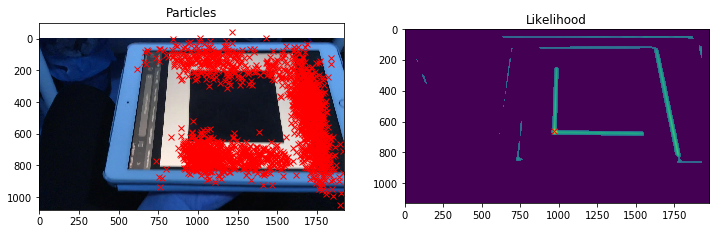

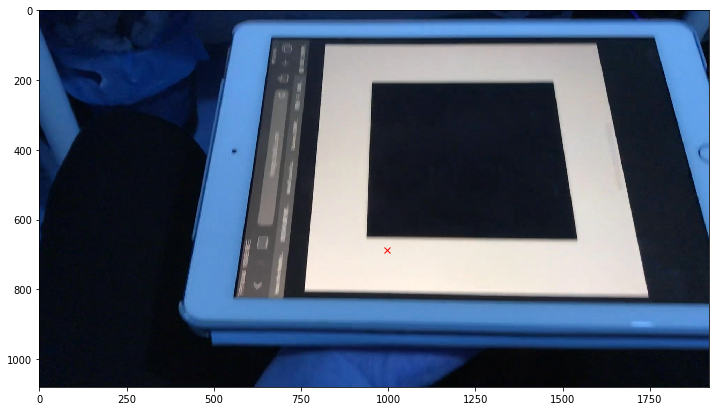

Processing Frame 5
[992.02351134 648.33452706]


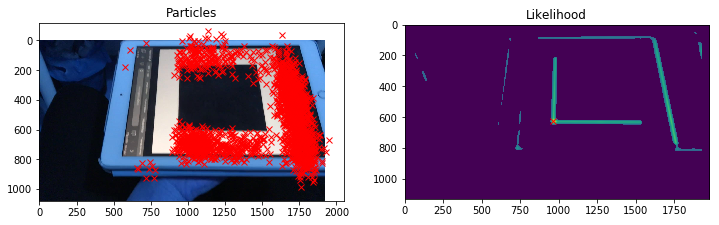

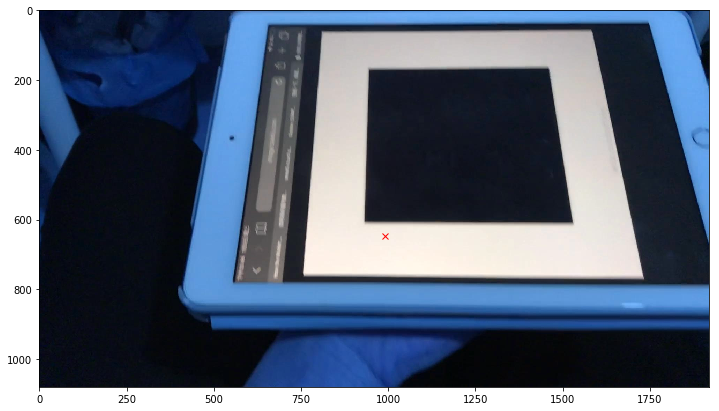

Processing Frame 6
[968.39186812 623.08402402]


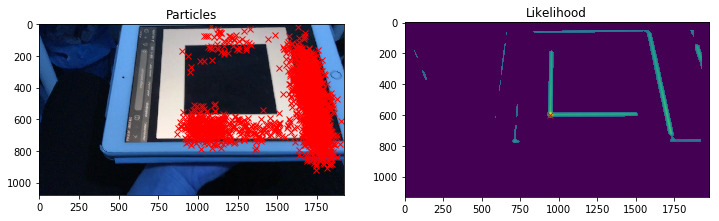

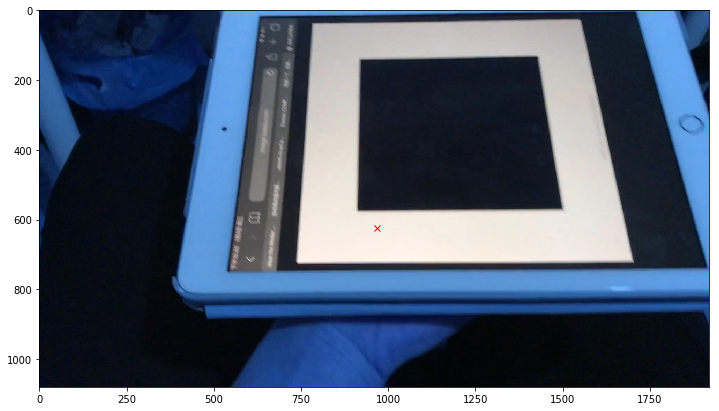

Processing Frame 7
[941.67979749 609.42353176]


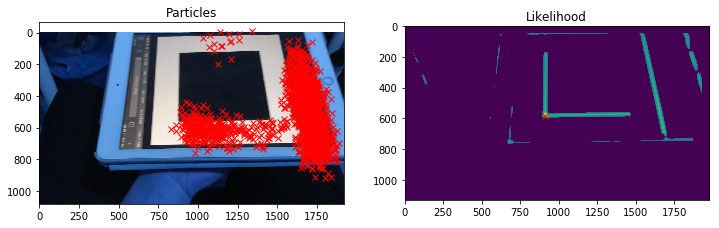

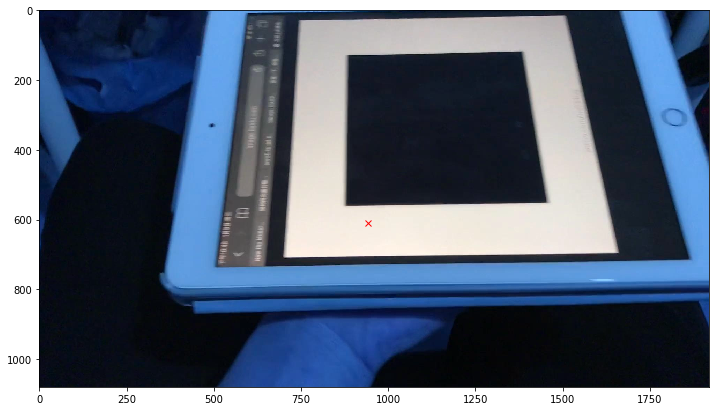

Processing Frame 8
[891.93055812 606.18694656]


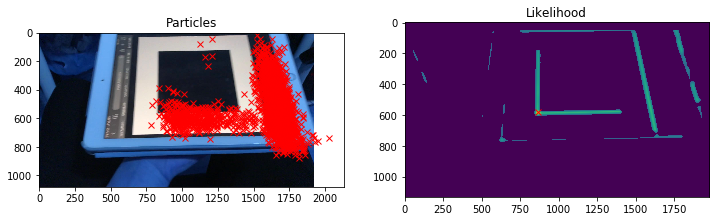

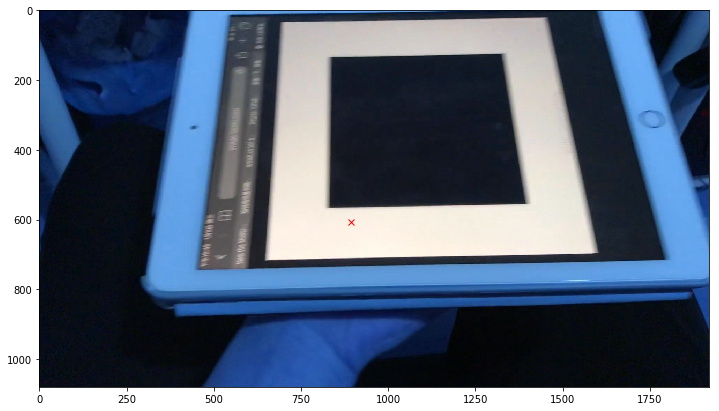

Processing Frame 9
[823.59611841 621.22018297]


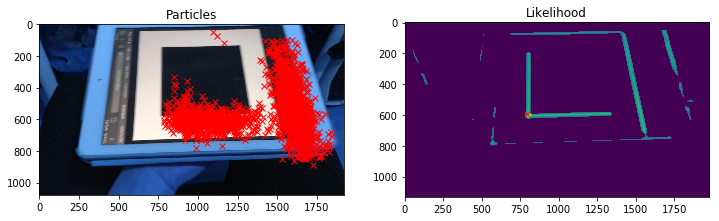

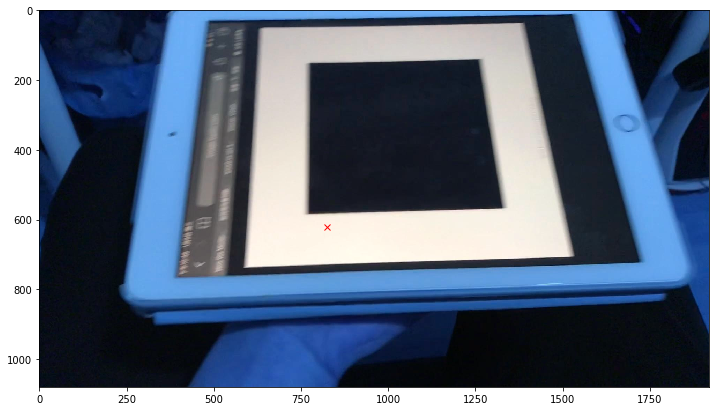

Processing Frame 10
[768.57501165 640.19763891]


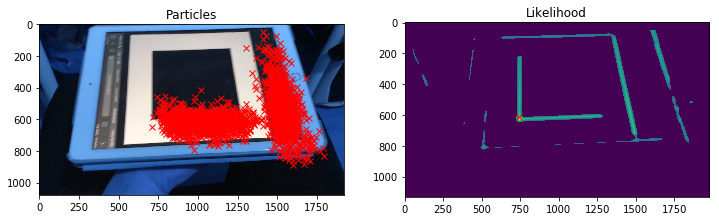

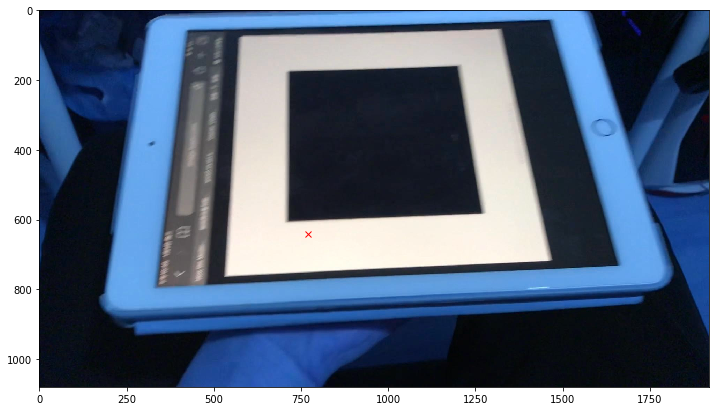

Processing Frame 11
Processing Frame 12
Processing Frame 13
Processing Frame 14
Processing Frame 15
Processing Frame 16
Processing Frame 17
Processing Frame 18
Processing Frame 19
Processing Frame 20
Processing Frame 21
Processing Frame 22
Processing Frame 23
Processing Frame 24
Processing Frame 25
Processing Frame 26
Processing Frame 27
Processing Frame 28
Processing Frame 29
Processing Frame 30
Processing Frame 31
Processing Frame 32
Processing Frame 33
Processing Frame 34
Processing Frame 35
Processing Frame 36
Processing Frame 37
Processing Frame 38
Processing Frame 39
Processing Frame 40
Processing Frame 41
Processing Frame 42
Processing Frame 43
Processing Frame 44
Processing Frame 45
Processing Frame 46
Processing Frame 47
Processing Frame 48
Processing Frame 49
Processing Frame 50
Processing Frame 51
Processing Frame 52
Processing Frame 53
Processing Frame 54
Processing Frame 55
Processing Frame 56
Processing Frame 57
Processing Frame 58
Processing Frame 59
Processing Frame 60


In [96]:
# instead of running the code here, you can also save the output of each function in a numpy array in HW2_Practical9c 
# and load it here. This could be handy if you need different hyperparameters for each corner.

LLs = HW2_Practical9c( 'llextra' )
#LRs = HW2_Practical9c( 'lr' )
#ULs = HW2_Practical9c( 'ul' )
#URs = HW2_Practical9c( 'ur' )


## Comment---(in order to save time and memory,only the first 10 images of the frames are displayed): 
Obviously this application is failed but I still want to say something about this.First, setting a threshold to the likelihood is really importance because otherwise the particles will stay on its own position because they consider they are landing correctly.